In [4]:
import csv
headers = []
table = []
with open('WHO-COVID-19-global-data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    flag = False
    for row in reader:
        if flag == False:
            headers.append(row)
            flag = True
        if row[1] == 'ET' or row[1] == 'SO' or row[1] == 'KE':        
            table.append(row)

In [5]:
from collections import defaultdict

country_data = defaultdict(lambda: defaultdict(list))
start_index = 0
for country in ['ET', 'KE', 'SO']:
    average_cases = defaultdict(list)
    average_deaths = defaultdict(list)

    for i in range(start_index, start_index + 500):
        temp_case = 0
        temp_death = 0
        count = 1
        for j in range(i, max(start_index-1, i-7), -1): #Srednia krocząca
            if table[j][1] == country:
                temp_case += int(table[j][4])
                temp_death += int(table[j][6])
                count +=1
        average_cases[table[i][0]] = temp_case / count
        average_deaths[table[i][0]] = temp_death / count

    start_index += 500
    
    country_data[(country, 'cases')] = average_cases
    country_data[(country, 'deaths')] = average_deaths

## Część 1
## Proste regresji
### a) 


In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

def regresion(y, x, n, x_label, y_label, x_ticks_labels):
    sum1 = sum(x[i] * y[i] for i in range(n))
    sum2 = sum(x[i] ** 2 for i in range(n))

    avg_x = sum(x)/n
    avg_y = sum(y)/n

    a  = (sum1 - n*avg_x*avg_y) / (sum2 - n*(avg_x**2))
    b = avg_y - a * avg_x

    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(x_ticks_labels)

    reg = [a*x[i] + b for i in range(n)]
    ax.plot(x, reg)
    plt.plot(x, y)

### Zachorowania

<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


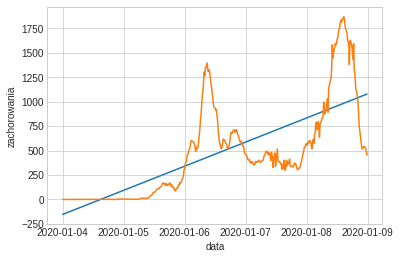

In [7]:
regresion(y =[float(country_data[('ET', 'cases')][key]) for key in country_data[('ET', 'cases')].keys()], x = [i for i in range(len(country_data[('ET', 'cases')].keys()))], n = 500, x_label = "data", y_label = "zachorowania", x_ticks_labels = country_data[('ET', 'cases')].keys())

### Zgony

<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


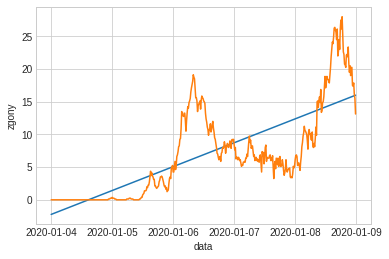

In [8]:
regresion(y =[float(country_data[('ET', 'deaths')][key]) for key in country_data[('ET', 'deaths')].keys()], x = [i for i in range(len(country_data[('ET', 'deaths')].keys()))], n = 500, x_label = "data", y_label = "zgony", x_ticks_labels = country_data[('ET', 'deaths')].keys())

### b) Przedziały najlepszych regresji

In [9]:
def find_best_regression(country, parameter, period):
    y = [float(country_data[(country, parameter)][key]) for key in country_data[(country, parameter)].keys()]
    x = [i for i in range(len(country_data[(country, parameter)].keys()))]

    best_i = -1
    best_error = 1000000

    for i in range(100,len(y) - period): #pomijam pierwsze ~100 wierszy gdzie nie ma/mało przypadków
        y_temp = y[i:i+period]
        x_temp = x[i:i+period]
        def evaluate_regression(y, x):
            n = len(y)
            sum1 = sum(x[i] * y[i] for i in range(n))
            sum2 = sum(x[i] ** 2 for i in range(n))

            avg_x = sum(x)/n
            avg_y = sum(y)/n

            a  = (sum1 - n*avg_x*avg_y) / (sum2 - n*(avg_x**2))
            b = avg_y - a * avg_x

            sum_of_squared_errors = 0
            for i in range(len(y_temp)):
                sum_of_squared_errors += (y_temp[i] - (a*x_temp[i]+b))**2
            return sum_of_squared_errors
        err = evaluate_regression(y_temp, x_temp)
        if err  < best_error:
            best_i = i
            best_error = err
        
    y_final = y[best_i:best_i+period]
    x_final = x[best_i:best_i+period]
    x_ticks_final = list(country_data[(country, parameter)].keys())[best_i:best_i+period]
    regresion(y= y_final, x = x_final, n =period, x_label = 'data', y_label=parameter, x_ticks_labels=x_ticks_final)


### Najlepsza regresja zachorowań - przedział 20 dni

<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


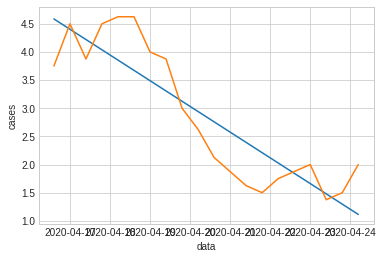

In [10]:
find_best_regression('ET', 'cases', 20)

### Najlepsza regresja zachorowań - przedział 30 dni


<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


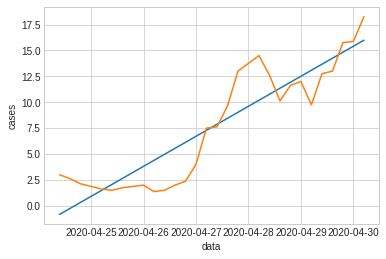

In [11]:
find_best_regression('ET', 'cases', 30)

### Najlepsza regresja zachorowań - przedział 70 dni

<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


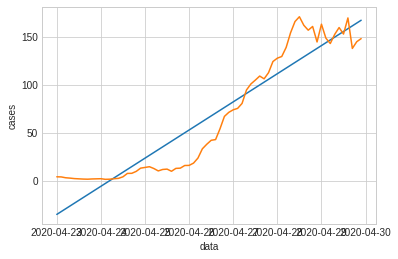

In [12]:
find_best_regression('ET', 'cases', 70)

### Najlepsza regresja zgonów - przedział 70 dni

<ipython-input-6-40f6ce52cf18>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


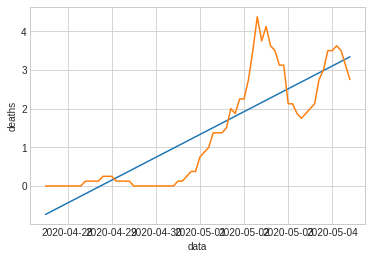

In [13]:
find_best_regression('ET', 'deaths', 70)


## Część 2.
## Liczenie korelacji

### a) Wyliczamy współczynik korelacji
#### Posłużę się wzorem na korelację liniową Pearsona:
<img src="korelacjaPearson.png">


In [18]:

def calculateCorrelation(targetCountry, plot = False):
    data1 = [float(country_data[('ET', 'cases')][key]) for key in country_data[('ET', 'cases')].keys()]
    data2 = [float(country_data[(targetCountry, 'cases')][key]) for key in country_data[(targetCountry, 'cases')].keys()]
    dates = [i for i in range(len(country_data[('ET', 'cases')].keys()))]

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.set_xlabel('daty')
        ax.set_ylabel('zachorowania')
        ax.plot(dates, data1, label = 'ET')
        ax.plot(dates, data2, label = targetCountry)
        ax.legend()

    coefficient = 0 
    sum1 = sum(data1)
    sum2 = sum(data2)
    avg1 = sum1/ len(data1)
    avg2 = sum1/ len(data2)

    standard_deviation1 = 0
    standard_deviation2 = 0
    for i in range(len(data1)):
        standard_deviation1 += (data1[i] - avg1)**2
        standard_deviation2 += (data2[i] - avg2)**2
    standard_deviation1 /= len(data1)
    standard_deviation2 /= len(data2)


    coefficient = 0 

    licznik = 0
    for i in range(len(data1)):
        licznik += (data1[i]-avg1)*(data2[i]-avg2)
    
    mianownik = len(data1)*np.sqrt(standard_deviation1)*np.sqrt(standard_deviation2)
    
    coefficient = licznik / mianownik
    return coefficient
    



0.6027832217397415


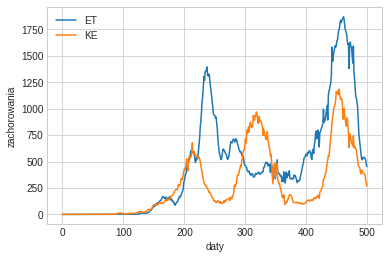

In [19]:
print(calculateCorrelation('KE', plot=True))

0.04942118923531358


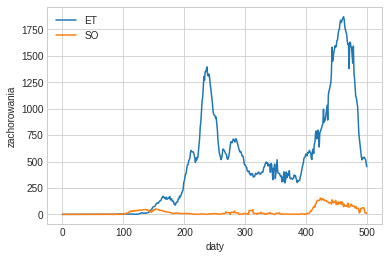

In [20]:
print(calculateCorrelation('SO', plot=True))

### Szukamy przedziałów największej korelacji

In [21]:
def findBestCorrelation(targetCountry, period):
    data1 = [float(country_data[('ET', 'cases')][key]) for key in country_data[('ET', 'cases')].keys()]
    data2 = [float(country_data[(targetCountry, 'cases')][key]) for key in country_data[(targetCountry, 'cases')].keys()]
    dates = [i for i in range(len(country_data[('ET', 'cases')].keys()))]

    def calculateCorrelation(targetCountry, d1, d2,ds, plot = False):
        if plot:
            fig = plt.figure()
            ax = plt.axes()
            ax.set_xlabel('daty')
            ax.set_ylabel('zachorowania')
            ax.plot(ds, d1, label = 'ET')
            ax.plot(ds, d2, label = targetCountry)
            ax.legend()

        sum1 = sum(data1)
        sum2 = sum(data2)
        avg1 = sum1/ len(d1)
        avg2 = sum1/ len(d2)

        standard_deviation1 = 0
        standard_deviation2 = 0
        for i in range(len(d1)):
            standard_deviation1 += (d1[i] - avg1)**2
            standard_deviation2 += (d2[i] - avg2)**2
        standard_deviation1 /= len(d1)
        standard_deviation2 /= len(d2)


        coefficient = 0 

        licznik = 0
        for i in range(len(d1)):
            licznik += (d1[i]-avg1)*(d2[i]-avg2)
        
        mianownik = len(d1)*np.sqrt(standard_deviation1)*np.sqrt(standard_deviation2)
        
        coefficient = licznik / mianownik
        return coefficient

    best_corel = 0
    best_i = -1

    for i in range(100, len(data1)- period): #pomijamy początkowe dni
        data1_temp = data1[i:i+period]
        data2_temp = data2[i:i+period]
        dates_temp = dates[i:i+period]

        temp = calculateCorrelation(targetCountry, data1_temp, data2_temp, dates_temp)
        if abs(temp) > best_corel:
            best_corel = abs(temp)
            best_i = i
    
    data1_final = data1[best_i:best_i+period]
    data2_final = data2[best_i:best_i+period]

    calculateCorrelation(targetCountry, data1_final, data2_final, dates[best_i:best_i+period], plot=True)
    return best_corel


### Przedział 20 dni:

0.9999999781202178


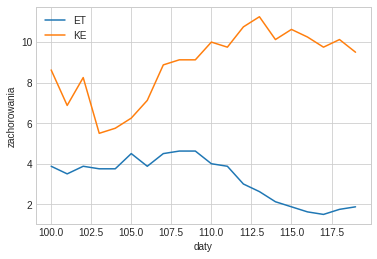

In [22]:
print(findBestCorrelation('KE', 20))


0.9999999789816332


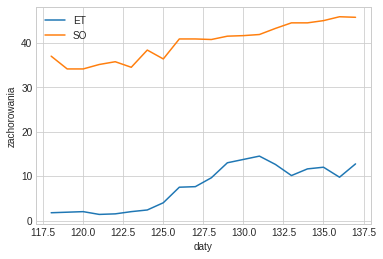

In [23]:
print(findBestCorrelation('SO', 20))


### Przedział 40 dni:

0.9999995559057201


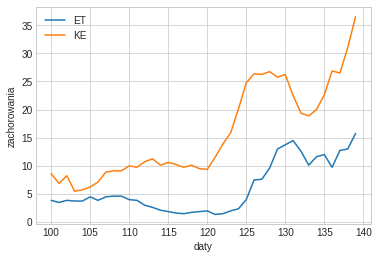

In [24]:
print(findBestCorrelation('KE', 40))


0.9999999789816332


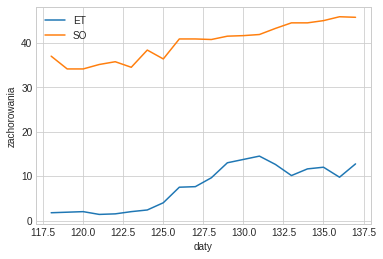

In [25]:
print(findBestCorrelation('SO', 20))


### Przedział 80 dni:

0.9999758263433263


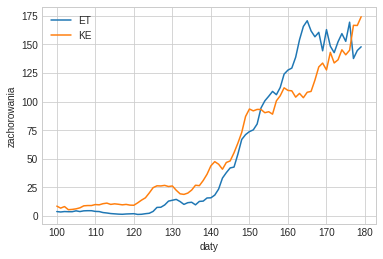

In [26]:
print(findBestCorrelation('KE', 80))


0.9998105644464512


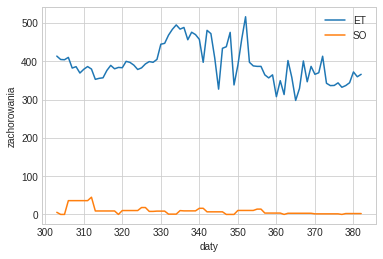

In [27]:
print(findBestCorrelation('SO', 80))


## Część 3.
## Testowanie hipotez

In [28]:
cases_ratio = defaultdict(list)
deaths_ratio = defaultdict(list)
country_population = dict()

country_population['ET'] = 114963588
country_population['SO'] = 15893222
country_population['KE'] = 53771296

#start: '2021-01-01'
#end: '2021-05-10'

### Liczenie liczby zachorowań i zgonów na 1000000 mieszkańców od 2021-01-01 do 2021-05-10

In [29]:
for country in ['ET', 'KE', 'SO']:
    flag = False
    for key in country_data[(country, 'cases')].keys():
        if flag == False:
            if key == '2021-01-01':
                flag = True
                cases_ratio[country].append(country_data[(country, 'cases')][key] * 1000000 / country_population[country])
        else:
            cases_ratio[country].append(country_data[(country, 'cases')][key] * 1000000 / country_population[country])
            if key == '2021-05-10':
                flag = False
                break

for country in ['ET', 'KE', 'SO']:
    flag = False
    for key in country_data[(country, 'deaths')].keys():
        if flag == False:
            if key == '2021-01-01':
                flag = True
                deaths_ratio[country].append(country_data[(country, 'deaths')][key] * 1000000 / country_population[country])
        else:
            deaths_ratio[country].append(country_data[(country, 'deaths')][key] * 1000000 / country_population[country])
            if key == '2021-05-10':
                flag = False
                break

### Testujemy hipotezę równości średnich metodą ANOVA

In [30]:
avgs_cases = defaultdict(float)
avgs_deaths = defaultdict(float)
n = 0
avgs_cases_general = 0
avgs_deaths_general = 0

for country in cases_ratio.keys():

    avgs_cases_general += np.sum(cases_ratio[country])
    avgs_deaths_general += np.sum(deaths_ratio[country])
    n += len(cases_ratio[country])
    avgs_cases[country] = np.sum(cases_ratio[country]) / len(cases_ratio[country])
    avgs_deaths[country] = np.sum(deaths_ratio[country]) / len(deaths_ratio[country])

avgs_cases_general /= n
avgs_deaths_general /= n

In [31]:
import scipy.stats

SSA_cases = len(cases_ratio['ET'])*sum([(avgs_cases[country] - avgs_cases_general)**2 for country in avgs_cases.keys()])
SSA_deaths = len(deaths_ratio['ET'])*sum([(avgs_deaths[country] - avgs_deaths_general)**2 for country in avgs_deaths.keys()])

SSTot_cases = 0
SSTot_deaths = 0

for country in avgs_cases.keys():
    for i in range(len(cases_ratio[country])):
        SSTot_cases += (cases_ratio[country][i] - avgs_cases_general)**2

for country in avgs_deaths.keys():
    for i in range(len(deaths_ratio[country])):
        SSTot_cases += (deaths_ratio[country][i] - avgs_deaths_general)**2

SSE_cases = SSTot_cases - SSA_cases
SSE_deaths = SSTot_deaths - SSA_deaths

MSA_cases = SSA_cases / 2
MSA_deaths = SSA_deaths / 2
MSE_cases = SSE_cases / 3*(len(cases_ratio['ET']) - 1)
MSE_deaths = SSE_deaths / 3*(len(deaths_ratio['ET']) - 1)

t_cases = MSA_cases / MSE_cases
t_deaths = MSA_deaths / MSE_deaths

p_value_cases = 2*scipy.stats.f.cdf(t_cases, dfn = 2, dfd = 3*(len(cases_ratio['ET']) - 1))
p_value_deaths = 2*scipy.stats.f.cdf(t_deaths, dfn = 2, dfd = 3*(len(deaths_ratio['ET']) - 1))

print(p_value_cases, p_value_deaths)

0.0035966150246073687 0.0


#### Zatem odrzucamy hipotezy o równości średnich zarówno zachorowań jak i zgonów

### Test średnich  

#### Nie znamy wariancji w poszczególnych krajach, dlatego z korzystamy z poniższego testu:

<img src="test.png">

#### i przeprowadzimy go na parach krajów: (ET, KE), (ET, SO), (KE, SO). W przypadku tej części zadania ograniczę się do testowania zachorowań.

In [32]:
standard_deviation = defaultdict(float)
for key in cases_ratio.keys():
    suma = 0
    for i in range(len(cases_ratio[key])):
        suma += (cases_ratio[key][i] - avgs_cases[key])**2
    
    suma /= len(cases_ratio[key])
    standard_deviation[key] = suma


def testWelcha(country1, country2):
    u = avgs_cases[country1] - avgs_cases[country2]
    u /= np.sqrt((standard_deviation[country1])/130 + (standard_deviation[country2])/130)

    v = (standard_deviation[country1]/130 + standard_deviation[country2]/130)**2
    v /= ((standard_deviation[country1]**2)/((130**2)*129) + (standard_deviation[country2]**2)/((130**2)*129))

    v = int(v)

    p_value = 2*scipy.stats.t.cdf(u, df=v)
    if p_value > 1:
        p_value = 2*(1- scipy.stats.t.cdf(u, df=v))
    return p_value

#### Test równości średnich ET i KE

In [33]:
print(testWelcha('ET', 'KE'))


0.7806646880333559


#### Brak podstaw do odrzucenia hipotezy

### Test równości średnich ET i SO

In [34]:
print(testWelcha('ET', 'SO'))

5.773159728050814e-15


#### Odrzucamy hipotezę

### Test równości średnich KE i SO


In [35]:
print(testWelcha('KE', 'SO'))

4.1041126053187327e-10


#### Odrzucamy hipotezę

### Możemy zatem wysunać wniosek, że test ANOVY odrzucił hipotezę przez brak równości średnich pomiędzy Etiopią a Somalią oraz Kenią a Somalią